In [408]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Checking for Missing values and Outliers

In [409]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [410]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [411]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [412]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [413]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

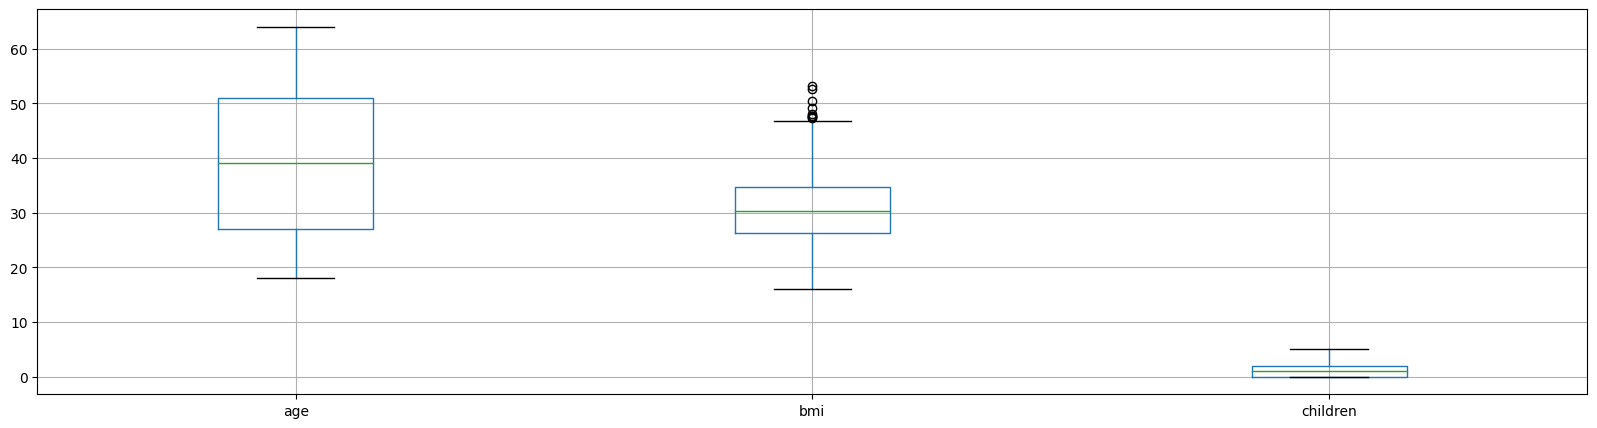

In [414]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

- BMI outliers of this magnitude are in fact possible.

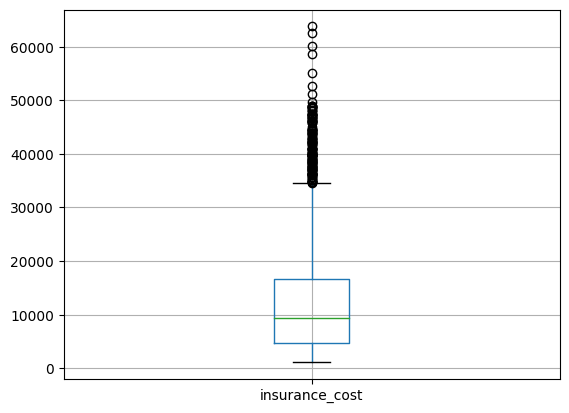

In [415]:
df.boxplot(column=['insurance_cost'])
plt.show()

# Data Prep

In [416]:
df = pd.get_dummies(df, columns=['gender'], 
                        #dummy_na=True, 
                        drop_first=True)

df = pd.get_dummies(df, columns=['smoker'], 
                        #dummy_na=True, 
                        drop_first=True)

In [417]:
df.head()

age     bmi  children     region  insurance_cost  gender_male  smoker_yes
0   18  33.770         1  southeast      1725.55230            1           0
1   18  34.100         0  southeast      1137.01100            1           0
2   18  26.315         0  northeast      2198.18985            0           0
3   18  38.665         2  northeast      3393.35635            0           0
4   18  35.625         0  northeast      2211.13075            0           0

In [418]:
df.tail()

age     bmi  children     region  insurance_cost  gender_male  \
1333   64  31.825         2  northeast     16069.08475            0   
1334   64  26.885         0  northwest     29330.98315            0   
1335   64  26.410         0  northeast     14394.55790            1   
1336   64  36.960         2  southeast     49577.66240            1   
1337   64  23.760         0  southeast     26926.51440            1   

      smoker_yes  
1333           0  
1334           1  
1335           0  
1336           1  
1337           1

In [419]:
# Create a dictionary to map region names to numbers
region_dict = {'northwest': 1, 'northeast': 2, 'southwest': 3, 'southeast': 4}

# Replace the region names with numbers using the dictionary
df['region'] = df['region'].replace(region_dict)

In [420]:
df.head()

age     bmi  children  region  insurance_cost  gender_male  smoker_yes
0   18  33.770         1       4      1725.55230            1           0
1   18  34.100         0       4      1137.01100            1           0
2   18  26.315         0       2      2198.18985            0           0
3   18  38.665         2       2      3393.35635            0           0
4   18  35.625         0       2      2211.13075            0           0

# Pipeline

In [421]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [422]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forest Pipeline

In [423]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [424]:
# Had to be changed to 6 as only 6 attributes
N_FEATURES_OPTIONS = [2, 4, 6]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10, 12, 14, 16]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]
# cv calculates the number of cross-validation folds. 
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.866:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__max_depth': 4}


1: 0.863
2: 

### Linear Regression Pipeline

In [425]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [426]:
N_FEATURES_OPTIONS = [2, 4, 6]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.757:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__normalize': False}


C:\Users\jkevi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


# Compare Model

In [427]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [428]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

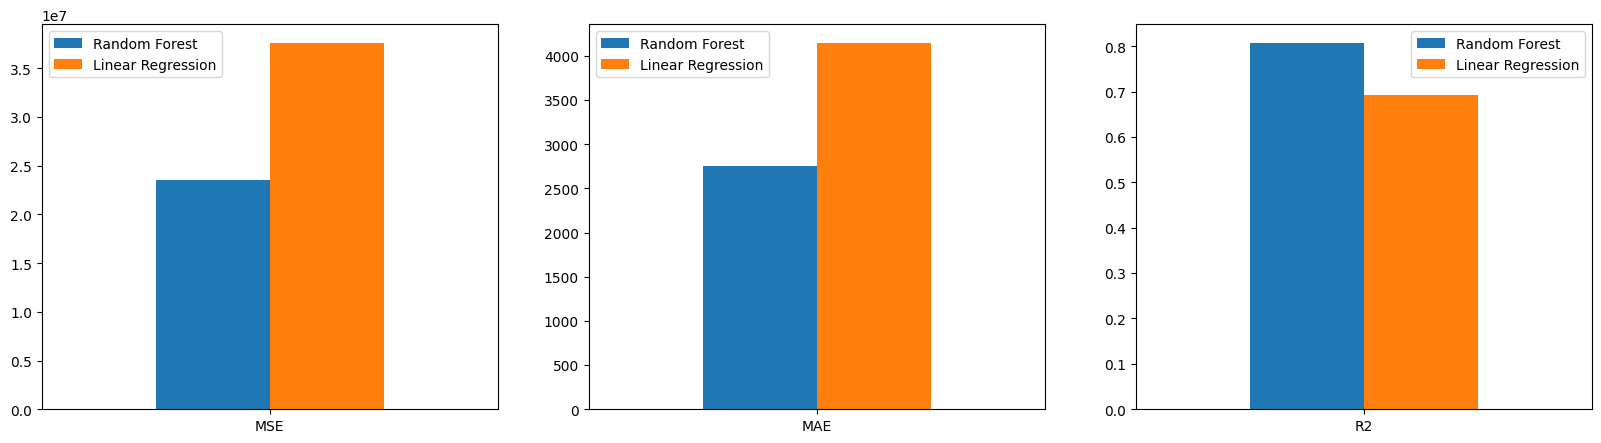

In [429]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

# Train a final model

In [430]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [431]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))